In [1]:
# Update iterator algorithm; and making recommendations; 
import collections
import compress_pickle
import copy
import itertools
import libsbml
import numpy as np
import operator
import os
import pickle
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline  

BIOMD_12 = 'BIOMD0000000012.xml'
BASE_DIR = '/Users/woosubshin/Desktop/AutomateAnnotation/'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
ALGO_DIR = os.path.join(DATA_DIR, "algo")
CHEBI_DIR = os.path.join(DATA_DIR, "chebi")
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
BIGG_DIR = '/Users/woosubshin/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")

PROJ_DIR = os.path.join(os.getcwd(), os.pardir)
AMAS_DIR = os.path.join(PROJ_DIR, "AMAS")
sys.path.append(PROJ_DIR)

SUPPL_DIR = os.path.join(PROJ_DIR, os.pardir, "AMAS_suppl")
ACCURACY_DIR = os.path.join(SUPPL_DIR, "data_for_credibility")

from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra
from AMAS import recommender
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools

spec_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_species_accuracy.csv'))
biomds_spec = np.unique(spec_ml_df['model'])
print("Number of BioModels to be analyzed for SPECIES: %d" % len(biomds_spec))

reac_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_reactions_accuracy.csv'))
biomds_reac = np.unique(reac_ml_df['model'])
print("Number of BioModels to be analyzed for REACTIONS: %d" % len(biomds_reac))

Number of BioModels to be analyzed for SPECIES: 306
Number of BioModels to be analyzed for REACTIONS: 131


In [2]:
# TODO: create and apply tools.MSSC filter to scoring methods; 
# test again with speed. revise paper and inform co authors

In [3]:
# get recom 
one_fpath = os.path.join(BIOMODEL_DIR, 'BIOMD0000000190.xml')
reader = libsbml.SBMLReader()
document = reader.readSBML(one_fpath)
model = document.getModel()
recom = recommender.Recommender(libsbml_fpath=one_fpath)

SPECIES_SAM = 'SAM'
REACTION_SAMDC = 'SAMdc'

In [4]:
recom.recommendSpecies(ids=['SAM'])

                                   SAM                                    
+----+--------------+---------------+------------------------------------+
|    | annotation   |   match score | label                              |
+====+==============+===============+====================================+
|  1 | CHEBI:15414  |         1.000 | S-adenosyl-L-methionine            |
+----+--------------+---------------+------------------------------------+
|  2 | CHEBI:59789  |         1.000 | S-adenosyl-L-methionine zwitterion |
+----+--------------+---------------+------------------------------------+



In [5]:
recom.getMatchScoreOfCHEBI('SAM', 'CHEBI:59789') 

1.0

In [8]:
recom.getMatchScoreOfRHEA('SSAT_for_S', 'RHEA:33099')

0.8

In [10]:
# updated version of getMatchScoreOfChEBI
res = recom.species.getCScores(['SAM'],
                               mssc='above',
                               cutoff=0.0)['SAM']
# searching for the match score
anot_res = next((np.round(v[1], cn.ROUND_DIGITS) for v in res if v[0] == 'CHEBI:59789'), 0.0)
anot_res

0.417

In [11]:
len(res)

148331

In [14]:
l = [(1,"juca"),(22,"james"),(53,"xuxa"),(44,"delicia")]

result = next((i for i, v in enumerate(l) if v[0] == 59), 0.0)
print(result)

0.0


In [5]:
inp_strs=['SAM', 'A']
unq_strs = list(set(inp_strs))
one_query, name_used = recom.species.prepareCounterQuery(specs=unq_strs,
                                                ref_cols=ref_df.columns,
                                                use_id=True) 
multi_mat = ref_df.dot(one_query)
multi_mat['CHEBI'] = chebi_df[cn.CHEBI]
for one_s in inp_strs:
  g_res = multi_mat.loc[:,[one_s, 'CHEBI']].groupby(['CHEBI']).max()[one_s]
  spec_cscore = tools.applyMSSC(pred=zip(g_res.index, g_res),
                                    mssc='top',
                                    cutoff=0.0)
  print(spec_cscore)

NameError: name 'ref_df' is not defined

In [97]:
spec_cscore

[('CHEBI:15625', 1.0)]

In [77]:
chebi_sub_df = sa.CHEBI_DF[sa.CHEBI_DF['chebi']=='CHEBI:15414']
charcount_sub_df = sa.CHARCOUNT_DF.loc[chebi_sub_df.index, :]
one_query, name_used = recom.species.prepareCounterQuery(specs=['SAM', 'A'],
                                                            ref_cols=charcount_sub_df.columns,
                                                            use_id=True)
multi_mat = charcount_sub_df.dot(one_query)
multi_mat['CHEBI'] = chebi_df[cn.CHEBI]

In [89]:
multi_mat

,SAM,A,CHEBI
13038,1.000000,0.959403,CHEBI:15414
13039,0.810443,0.782624,CHEBI:15414
13040,0.883272,0.858362,CHEBI:15414
13041,0.580948,0.605530,CHEBI:15414
13042,0.796715,0.779812,CHEBI:15414
13043,0.655562,0.706188,CHEBI:15414
13044,0.987763,0.975372,CHEBI:15414
13045,0.949386,0.918629,CHEBI:15414
13046,0.553399,0.606780,CHEBI:15414
13047,0.365148,0.467099,CHEBI:15414


In [8]:
inp_id='SAMdc'
specs2predict = recom.reactions.reaction_components[inp_id] 
spec_results = recom.getSpeciesListRecommendation(pred_ids=specs2predict,
                                                 update=False,
                                                 method='cdist')

In [9]:
recom.getMatchScoreOfCHEBI(inp_id='SAM', inp_chebi='CHEBI:15414')

1.0

In [69]:
res = recom.species.getCScores(inp_strs=['SAM', 'A'], mssc='above', cutoff=0.0)
# np.max([val[1] for val in res['SAM'] if val[0]=='CHEBI:67040'])

In [84]:
for one_s in res.keys():
  g_res = multi_mat.loc[:,[one_s, 'CHEBI']].groupby(['CHEBI']).max()
  print(g_res)

                    A
CHEBI                
CHEBI:15414  0.975372
             SAM
CHEBI           
CHEBI:15414  1.0


In [83]:
g_res

,SAM
CHEBI,
CHEBI:15414,1.0


,SAM
CHEBI,
CHEBI:10,0.339683
CHEBI:100,0.333333
CHEBI:10000,0.348155
CHEBI:100000,0.158610
CHEBI:100001,0.279040
...,...
CHEBI:99995,0.368608
CHEBI:99996,0.335272
CHEBI:99997,0.347170


In [13]:
ref_df=sa.CHARCOUNT_DF
chebi_df=sa.CHEBI_DF

In [16]:
inp_strs=['SAM']
mssc='above'
cutoff=0.0
unq_strs = list(set(inp_strs))
one_query, name_used = recom.species.prepareCounterQuery(specs=unq_strs,
                                                ref_cols=ref_df.columns,
                                                use_id=False) 
multi_mat = ref_df.dot(one_query)
cscores = dict()
for spec in unq_strs:
  spec_cscore = tools.applyMSSC(pred=zip(chebi_df[cn.CHEBI], multi_mat[spec]),
                                mssc=mssc,
                                cutoff=cutoff)
  spec_cscore.sort(key=operator.itemgetter(1), reverse=True)
  cscores[spec] = spec_cscore

In [39]:
one_res.iloc[2, :]

Series([], Name: (CHEBI:100, 0.3333333333333334), dtype: float64)

In [18]:
chebi_df[cn.CHEBI]

0         CHEBI:18357
1         CHEBI:18357
2         CHEBI:18357
3         CHEBI:18357
4         CHEBI:18357
             ...     
431019    CHEBI:99995
431020    CHEBI:99996
431021    CHEBI:99997
431022    CHEBI:99998
431023    CHEBI:99999
Name: chebi, Length: 431024, dtype: object

In [19]:
multi_mat[spec]

0         0.000000
1         0.115470
2         0.000000
3         0.230940
4         0.210819
            ...   
431019    0.368608
431020    0.335272
431021    0.347170
431022    0.334367
431023    0.348803
Name: SAM, Length: 431024, dtype: float64

In [ ]:

pred_formulas = dict()
for one_recom in spec_results:
  chebis = [val[0] for val in one_recom.candidates]
  forms = list(set([cn.REF_CHEBI2FORMULA[k] \
         for k in chebis if k in cn.REF_CHEBI2FORMULA.keys()]))
  pred_formulas[one_recom.id] = forms
query_df = pd.DataFrame(0, 
                        index=ra.REF_MAT.columns,
                        columns=[inp_id])
for one_spec_key in pred_formulas.keys():
    one_spec = pred_formulas[one_spec_key]
    # For each one_rid, set the values 1.0
    query_df.loc[[val for val in one_spec if val in query_df.index], inp_id] = 1
sub_ref_mat = ra.REF_MAT.loc[inp_rhea, :]
num_matches = int(sub_ref_mat.dot(query_df))

In [56]:
type(ref_df)

tuple

In [7]:
one_fpath = os.path.join(BIOMODEL_DIR, biomds_reac[3])
recom = recommender.Recommender(libsbml_fpath=one_fpath)
print(recom.reactions.exist_annotation)
print(recom.reactions.reaction_components['Cdc2Phos'])

{'Cdc2Phos': ['RHEA:10596']}
['G2K', 'PG2']


In [5]:
recom.getSpeciesListRecommendation(['PG2', 'G2K'])

[Recommendation(id='PG2', candidates=[('CHEBI:15883', 0.943), ('CHEBI:27647', 0.943)], urls=['https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A15883', 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A27647'], labels=["P(1),P(4)-bis(5'-guanosyl) tetraphosphate", 'prostaglandin G2']),
 Recommendation(id='G2K', candidates=[('CHEBI:165341', 0.866)], urls=['https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A165341'], labels=['PGK2'])]

In [6]:
recom.reactions.getRScores(spec_dict=recom.species.formula,
                           reacs=['Cdc2Phos'],
                           mssc='top', cutoff=0.0)

{'Cdc2Phos': [('RHEA:11732', 0.6666666666666666),
  ('RHEA:42600', 0.6666666666666666),
  ('RHEA:48648', 0.6666666666666666),
  ('RHEA:48652', 0.6666666666666666),
  ('RHEA:48672', 0.6666666666666666),
  ('RHEA:48776', 0.6666666666666666),
  ('RHEA:48796', 0.6666666666666666),
  ('RHEA:50432', 0.6666666666666666),
  ('RHEA:50448', 0.6666666666666666),
  ('RHEA:52488', 0.6666666666666666),
  ('RHEA:52520', 0.6666666666666666),
  ('RHEA:53932', 0.6666666666666666),
  ('RHEA:53936', 0.6666666666666666),
  ('RHEA:53940', 0.6666666666666666),
  ('RHEA:60784', 0.6666666666666666),
  ('RHEA:60800', 0.6666666666666666)]}

In [8]:
E_COLI_PATH = os.path.join(cn.TEST_DIR, 'e_coli_core.xml')
INIT_SPEC_FORMULA = {'M_accoa_c': ['C23N7O17P3S'],
                     'M_for_c': ['CO2'], 
                     'M_adp_c': ['C115N8O85', 'C21ClN3O2', 'C19N2O2S',
                                 'C17Cl2F3N7O2S', 'C16NO6', 'C19O2',
                                 'C26N7O2S', 'C19O9P', 'C28N6OS',
                                 'C16F3IN2O4', 'C35N4O4', 'C18N4O11',
                                 'C26FIN5O4', 'C20O4', 'C12',
                                 'C10N5O10P2', 'C8NO6', 'C29N6O4S',
                                 'C18ClN2O6S2', 'C27O5', 'C18O2',
                                 'C9N4O5', 'C20N2O5S', 'C101N7O75',
                                 'C14N2O'],
                     'M_pyr_c': ['C3O3'],
                     'M_coa_c': ['C21N7O16P3S'],
                     'M_fdp_c': ['C6O12P2'],
                     'M_f6p_c': ['C6O9P'],
                     'M_atp_c': ['C20O4', 'C18ClN2O6S2'],
                     'M_h_c': ['H']}

REACTION_CANDIDATES = {'R_PFK': [('RHEA:12420', 0.8), ('RHEA:13377', 0.8),
                                 ('RHEA:14213', 0.8), ('RHEA:15653', 0.8),
                                 ('RHEA:16109', 0.8), ('RHEA:20105', 0.8)],
                       'R_PFL': [('RHEA:11844', 1.0), ('RHEA:17425', 0.8),
                                 ('RHEA:22988', 0.8), ('RHEA:22992', 0.8),
                                 ('RHEA:28042', 0.8), ('RHEA:12765', 0.667),
                                 ('RHEA:21912', 0.667), ('RHEA:44140', 0.667)]}

R_PFK = 'R_PFK'
R_PFL = 'R_PFL'
REACTIONS = [R_PFK, R_PFL]


ONE_RHEA = 'RHEA:12420'
ONE_CHEBI = 'CHEBI:15378'
MOLECULE_H = 'H'
TWO_CHEBI = 'CHEBI:58695'
MOLECULE_C6O9P = 'C6O9P'

SPECIES_ATP = 'M_atp_c'
CHEBI_ATP = 'CHEBI:30616'
FORMULA_ATP = 'C10N5O13P3'

ONE_RES_CHEBI = {'M_atp_c': ['CHEBI:30616']}
ONE_SPEC2FORMULA = {'M_atp_c': ['C10N5O13P3']}

In [9]:
reac_cl = ra.ReactionAnnotation(libsbml_fpath = E_COLI_PATH)
reac_cl.candidates = REACTION_CANDIDATES
anot_iter = it.Iterator(cur_spec_formula=copy.deepcopy(INIT_SPEC_FORMULA),
                             reaction_cl=reac_cl,
                             reactions_to_update=REACTIONS)

In [10]:
res = anot_iter.getUpdatedMatchScore(cur_spec_formulas=copy.deepcopy(INIT_SPEC_FORMULA),
                                          inp_spec2formula_dict=ONE_SPEC2FORMULA)
# self.assertEqual(np.round(res[it.NEW_SCORE], 2),
#                  0.68)
# self.assertEqual(np.round(res[it.OLD_SCORE], 2),
#                  0.65)
# self.assertTrue(res[it.INCREASED])

In [11]:
res

{'new_score': 1.0, 'old_score': 0.9, 'is_increased': True}

In [12]:
# First, collect all species IDs to annotate
use_exist_species_annotation=False
spec_res=None
pred_ids=recom.getReactionIDs()
spec_method='cdist'
specs_to_annotate = list(set(itertools.chain(*[recom.reactions.reaction_components[val] \
                                               for val in pred_ids])))
if use_exist_species_annotation:
  pred_formulas = {val:recom.species.exist_annotation_formula[val] \
                   for val in specs_to_annotate \
                   if val in recom.species.exist_annotation_formula.keys()}
else:
  pred_formulas = {}
remaining_species = [val for val in specs_to_annotate if val not in pred_formulas.keys()]
# Get annotation of collected species
if len(remaining_species) > 0:
  if spec_res:
    spec_results = [val for val in spec_res if val.id in remaining_species]
  else:
    # No updates; use MSSC Top, cutoff 0.0. 
    spec_results = recom.getSpeciesListRecommendation(pred_ids=remaining_species,
                                                      update=False,
                                                      method=spec_method)
  for one_recom in spec_results:
    chebis = [val[0] for val in one_recom.candidates]
    forms = list(set([cn.REF_CHEBI2FORMULA[k] \
             for k in chebis if k in cn.REF_CHEBI2FORMULA.keys()]))
    pred_formulas[one_recom.id] = forms
# # Predict reaction annotations. 
pred_res = recom.reactions.getRScores(spec_dict=pred_formulas,
                                     reacs=pred_ids,
                                     mssc='top',
                                     cutoff=0.0)

In [13]:
spec_dict = pred_formulas
reacs=pred_ids
ref_mat=ra.REF_MAT

r2pred_spec_formulas = dict()
for one_rid in reacs:
  r2pred_spec_formulas[one_rid] = {spec:spec_dict[spec] \
                                   for spec in recom.reactions.reaction_components[one_rid]}

In [14]:
r2comb_spec_formulas = dict()
for one_rid in reacs:
  r2comb_spec_formulas[one_rid] = list(set(itertools.chain(*[spec_dict[spec] \
                                   for spec in recom.reactions.reaction_components[one_rid]])))

In [15]:
r2comb_spec_formulas

{'G2K_Creation': ['C13N2'],
 'G1K_Creation': ['C2'],
 'Cdc2Phos': ['C13N2', 'C8ClN7O'],
 'G2R_Creation': ['C13N2', 'Fe', 'C20O7'],
 'PG2R_Creation': ['Fe', 'C44NO8P', 'C8ClN7O'],
 'Rum1DegInG2R': ['C13N2', 'C20O7'],
 'Rum1Deg': ['Fe'],
 'Rum1DegInPG2R': ['C44NO8P', 'C8ClN7O'],
 'RumDegInG1R': ['C2', 'C46NO8'],
 'G2K_dissoc': ['C13N2'],
 'PG2_dissoc': ['C8ClN7O'],
 'G1K_Dissociation': ['C2'],
 'PG2R_Dissociation': ['Fe', 'C44NO8P'],
 'G2R_Dissociation': ['Fe', 'C20O7'],
 'G1R_Dissociation': ['Fe', 'C46NO8'],
 'G1R_Binding': ['C2', 'Fe', 'C46NO8'],
 'G2R_Dissociation_UbE': ['Fe', 'C20O7'],
 'PG2R_Dissociation_UbE': ['Fe', 'C44NO8P'],
 'Rum1_Production': ['Fe'],
 'Rum1_Deg_SPF': ['Fe'],
 'IE_Reaction': ['C29N12O9S', 'C12N3O5S'],
 'UbE_Reaction': ['C5N4S', 'C23O12'],
 'UbE2_Reaction': ['C5N4S', 'C23O12'],
 'Wee1_Reaction': ['C16N3O5', 'C4O'],
 'Cdc25_Reaction': ['C27O3', 'C28O']}

In [22]:
# mssc = 'top'
# cutoff = 0.0

# j_rscores = dict()
# for rid in r2comb_spec_formulas.keys():
#   score = nonzero_cols.apply(lambda x: get_jaccard(x, r2comb_spec_formulas[rid]))
#   reac_rscore = tools.applyMSSC(pred=zip(score.index, score),
#                                 mssc=mssc,
#                                 cutoff=cutoff)
#   reac_rscore.sort(key=operator.itemgetter(1), reverse=True)
#   j_rscores[rid] = reac_rscore  

In [23]:
cn.REF_DIR

'/Users/woosubshin/Desktop/AutomateAnnotation/AMAS/AMAS/files'

In [17]:
# prepare query df for prediction
query_df = pd.DataFrame(0, 
                        index=ref_mat.columns,
                        columns=reacs)
for one_rid in reacs:
  one_set_species = r2pred_spec_formulas[one_rid]
  # for each species element of the select reaction
  for spec_key in one_set_species.keys():
    one_spec = one_set_species[spec_key]
    # For each one_rid, set the values 1.0
    query_df.loc[[val for val in one_spec if val in query_df.index], one_rid] = 1
multi_mat = ref_mat.dot(query_df)

In [30]:
multi_mat.max()

G2K_Creation             0
G1K_Creation             1
Cdc2Phos                 0
G2R_Creation             1
PG2R_Creation            1
Rum1DegInG2R             1
Rum1Deg                  1
Rum1DegInPG2R            1
RumDegInG1R              1
G2K_dissoc               0
PG2_dissoc               0
G1K_Dissociation         1
PG2R_Dissociation        1
G2R_Dissociation         1
G1R_Dissociation         1
G1R_Binding              1
G2R_Dissociation_UbE     1
PG2R_Dissociation_UbE    1
Rum1_Production          1
Rum1_Deg_SPF             1
IE_Reaction              0
UbE_Reaction             1
UbE2_Reaction            1
Wee1_Reaction            1
Cdc25_Reaction           1
dtype: int64

In [32]:
type(max_multi_mat)

pandas.core.series.Series

In [35]:
multi_mat[multi_mat['Rum1Deg']==1]['Rum1Deg'].index

Index(['RHEA:11148', 'RHEA:11436', 'RHEA:11484', 'RHEA:11972', 'RHEA:12332',
       'RHEA:12496', 'RHEA:12909', 'RHEA:13089', 'RHEA:13521', 'RHEA:13841',
       ...
       'RHEA:66040', 'RHEA:66456', 'RHEA:66504', 'RHEA:66508', 'RHEA:67656',
       'RHEA:67660', 'RHEA:71231', 'RHEA:71235', 'RHEA:71239', 'RHEA:71659'],
      dtype='object', length=247)

In [10]:
# dum_dict = dict()
# max_multi_mat = np.max(multi_mat)
# for one_idx in max_multi_mat.index:
#   dum_dict[one_idx] = np.min(np.sum(ref_mat.loc[multi_mat[multi_mat[one_idx]==max_multi_mat[one_idx]][one_idx].index,:],1))

In [14]:
dum_series = pd.Series(0, index=max_multi_mat.index)
for idx in dum_series.index:
  dum_series.at[idx] = np.min(np.sum(ref_mat.loc[multi_mat[multi_mat[idx]==max_multi_mat[idx]][idx].index,:],1))

In [15]:
dum_series

ODC           2
SAMdc         4
SSAT_for_S    5
SSAT_for_D    5
PAO_for_aD    5
PAO_for_aS    5
SpdS          5
SpmS          5
MAT           4
VCoA          5
VacCoA        5
P_efflux      1
aD_efflux     4
dtype: int64

In [18]:
np.sum(ref_mat.loc[multi_mat[multi_mat['ODC']==max_multi_mat['ODC']]['ODC'].index,:],1)

RHEA:22964    4
RHEA:28827    2
RHEA:59048    4
dtype: int64

In [19]:
comp_num = pd.Series({k:len(recom.reactions.reaction_components[k]) \
 for k in recom.reactions.reaction_components.keys()})

In [21]:
div_mat = multi_mat.divide(dum_series, axis=1)

In [36]:
'Abc'.lower()

'abc'

In [43]:
# Jaccard Index
jac_numer_mat = copy.deepcopy(multi_mat)
rev_denom_mat = (1-ref_mat).dot(1-query_df)
count = (rev_denom_mat == 0).sum()

In [48]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1],
                  [1, 1, 0]])
y_pred = np.array([[1, 1, 1],
                  [1, 0, 0]])
jaccard_score(y_true[0], y_pred[0])

0.6666666666666666

In [58]:
ref_mat.apply(lambda x: x.idxn(), axis=1)

RHEA:10000      C5NO
RHEA:10004      C8NS
RHEA:10008        OR
RHEA:10012    C10N2O
RHEA:10016      C5NO
               ...  
RHEA:74391        CN
RHEA:74395      C3O3
RHEA:74399      C3O3
RHEA:74403      C3O3
RHEA:74407      C3O3
Length: 15451, dtype: object

In [75]:
val for val in nonzero_cols:
  print(val)
  break

SyntaxError: invalid syntax (2885624916.py, line 1)

In [115]:
# Save to nonzero cols
nonzero_cols = ref_mat.apply(lambda x: [y for y, z in x.items() if z != 0.0], axis=1)

compress_pickle.dump(nonzero_cols,
                     os.path.join(cn.REF_DIR, 'ref_nonzero_cols.lzma'),
                     compression="lzma",
                     set_default_extension=False)

In [82]:
nonzero_cols['RHEA:10000']

['C5NO', 'C5O2', 'N', 'O']

In [88]:
def get_jaccard(inp1, inp2):
  """
  Get jaccard score of two lists; 
  
  Parameters
  ----------
  inp1: list-str
  inp2: list-str
  
  Returns
  -------
  : float
  """
  inters = set(inp1).intersection(inp2)
  uni = set(inp1).union(inp2)
  return len(inters) / len(uni)

In [89]:
get_jaccard(['C5NO', 'C5O2', 'N', 'O'], ['C9N3O'])

0.0

In [92]:
nonzero_cols.apply(lambda x: get_jaccard(x, one_spec))

0.25

In [65]:
ref_mat.shape

(15451, 4003)

In [53]:
ref_mat[(ref_mat.select_dtypes(include=['number']) != 0).any(1)]

,C15N4O3,C17N4O3,C6O2(C5H8)n,C16N2O2,C6O8PR,C3O3,C10N4O6S2,C59O6,C33O8,C5O7P2,...,C31N2O26SR,(C5O6PR)n.C9H12N2O9P,C34N3O16PS,C22N2O2,C9INO3,C10N2O7PS,C6NS2,C60N22O15S,C33N11O26P4R,(C9O10P)n.C74H122N2O22P3
RHEA:10000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:10004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:10008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:10012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:10016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:74395,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:74399,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RHEA:74403,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([1.5345e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

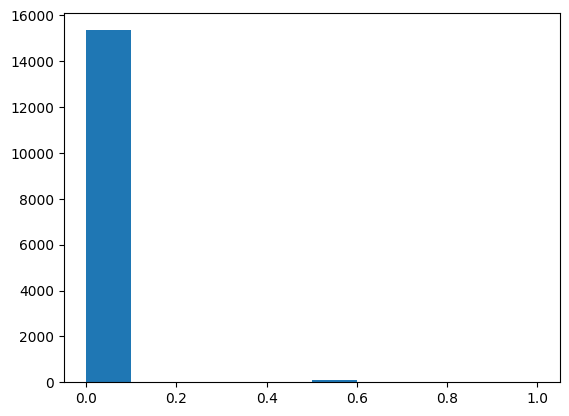

In [25]:
plt.hist(div_mat['ODC'])

In [17]:
query_colsum = query_df.sum(0)
query_colsum

ODC           2
SAMdc         2
SSAT_for_S    5
SSAT_for_D    5
PAO_for_aD    2
PAO_for_aS    2
SpdS          3
SpmS          3
MAT           2
VCoA          3
VacCoA        3
P_efflux      1
aD_efflux     1
dtype: int64

In [4]:
s = recom.recommendSpecies(['A'])

                               A                                
+----+--------------+---------------+--------------------------+
|    | annotation   |   match score | label                    |
+====+==============+===============+==========================+
|  1 | CHEBI:15625  |         1.000 | S-adenosylmethioninamine |
+----+--------------+---------------+--------------------------+



In [14]:
# recom2 = recommender.Recommender(libsbml_fpath=ecoli_fpath)
REACTION_ODC = 'ODC'
REACTION_SAMDC = 'SAMdc'
reacs = recom.getReactionListRecommendation(pred_ids=[REACTION_ODC, REACTION_SAMDC])

In [16]:
recom.recommendReaction(['SAMdc'])

                                      SAMdc                                      
+----+--------------+---------------+-------------------------------------------+
|    | annotation   |   match score | label                                     |
+====+==============+===============+===========================================+
|  1 | RHEA:15981   |         1.000 | adenosylmethionine decarboxylase activity |
+----+--------------+---------------+-------------------------------------------+



In [18]:
biggs = [val for val in os.listdir(BIGG_DIR) if val[-4:]=='.xml']
bigg_num_species = []
for idx, one_bigg in enumerate(biggs):
  if idx % 10 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())
  bigg_num_species.append(len(specs2evaluate))

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


In [22]:
np.mean(bigg_num_species)

1233.638888888889

In [ ]:
spec_dict = {'M_f6p_c': ['C6O9P'],
         'M_fdp_c': ['C6O12P2'],
         'M_atp_c': ['C30N4O29P3'],
         'M_h_c': ['H', 'C6N3O2', 'C6N3O', '[3He]', 'C12N6O3'],
         'M_adp_c': ['C30O8P', 'C39O8P']}
recom2.reactions.getRScores(spec_dict=spec_dict,
                                  reacs=['R_PFK'])['R_PFK']

In [19]:
reacs=['R_PFK']
ref_mat=ra.REF_MAT


r2pred_spec_formulas = dict()
for one_rid in reacs:
  r2pred_spec_formulas[one_rid] = {spec:spec_dict[spec] \
                                    for spec in recom2.reactions.reaction_components[one_rid]}
# prepare query df for prediction
query_df = pd.DataFrame(0, 
                        index=ref_mat.columns,
                        columns=reacs)
for one_rid in reacs:
  one_set_species = r2pred_spec_formulas[one_rid]
  # for each species element of the select reaction
  for spec_key in one_set_species.keys():
    one_spec = one_set_species[spec_key]
    # For each one_rid, set the values 1.0
    query_df.loc[[val for val in one_spec if val in query_df.index], one_rid] = 1
multi_mat = ref_mat.dot(query_df)
# ref_rowsum = ref_mat.sum(1)
query_colsum = query_df.sum(0)
# divided by the number of elements of the QUERY
div_mat = multi_mat.divide(query_colsum, axis=1)
rscores = dict()
for reac in reacs:
  reac_rscore = list(zip(div_mat.index, div_mat[reac]))
  reac_rscore.sort(key=operator.itemgetter(1), reverse=True)
  rscores[reac] = reac_rscore 

In [20]:
rscores

{'R_PFK': [('RHEA:12420', 0.5),
  ('RHEA:13377', 0.5),
  ('RHEA:13613', 0.5),
  ('RHEA:14213', 0.5),
  ('RHEA:15653', 0.5),
  ('RHEA:16109', 0.5),
  ('RHEA:16769', 0.5),
  ('RHEA:20105', 0.5),
  ('RHEA:20641', 0.5),
  ('RHEA:33803', 0.5),
  ('RHEA:69536', 0.5),
  ('RHEA:70907', 0.5),
  ('RHEA:70911', 0.5),
  ('RHEA:10708', 0.3333333333333333),
  ('RHEA:10972', 0.3333333333333333),
  ('RHEA:11028', 0.3333333333333333),
  ('RHEA:11064', 0.3333333333333333),
  ('RHEA:11460', 0.3333333333333333),
  ('RHEA:11860', 0.3333333333333333),
  ('RHEA:12120', 0.3333333333333333),
  ('RHEA:12556', 0.3333333333333333),
  ('RHEA:12905', 0.3333333333333333),
  ('RHEA:13077', 0.3333333333333333),
  ('RHEA:13117', 0.3333333333333333),
  ('RHEA:13333', 0.3333333333333333),
  ('RHEA:13497', 0.3333333333333333),
  ('RHEA:13553', 0.3333333333333333),
  ('RHEA:14033', 0.3333333333333333),
  ('RHEA:14209', 0.3333333333333333),
  ('RHEA:14605', 0.3333333333333333),
  ('RHEA:14797', 0.3333333333333333),
  ('RHEA

In [30]:
RESULT_RECOM = cn.Recommendation('R_PFK',
                                 [('RHEA:12420', 0.6), ('RHEA:13377', 0.6)],
                                 ['https://www.rhea-db.org/rhea/12420', 'https://www.rhea-db.org/rhea/13377'],
                                 ['tagatose-6-phosphate kinase activity', 'phosphoglucokinase activity'])

In [31]:
res = recom.getMarkdownFromRecommendation(rec=RESULT_RECOM,
                                               show_url=False)

In [32]:
res

'                                   R_PFK                                    \n+----+--------------+---------------+--------------------------------------+\n|    | annotation   |   match score | label                                |\n+====+==============+===============+======================================+\n|  1 | RHEA:12420   |         0.600 | tagatose-6-phosphate kinase activity |\n+----+--------------+---------------+--------------------------------------+\n|  2 | RHEA:13377   |         0.600 | phosphoglucokinase activity          |\n+----+--------------+---------------+--------------------------------------+'

In [21]:
recom.getReactionIDs()

['ODC',
 'SAMdc',
 'SSAT_for_S',
 'SSAT_for_D',
 'PAO_for_aD',
 'PAO_for_aS',
 'SpdS',
 'SpmS',
 'MAT',
 'VCoA',
 'VacCoA',
 'P_efflux',
 'aD_efflux']

In [23]:
res2 = recom.getReactionRecommendation(pred_id='aD_efflux', get_df=True)

In [24]:
res2

,annotation,match score,label
aD_efflux,,,
1,RHEA:23928,0.25,acetylspermidine deacetylase activity
2,RHEA:27578,0.25,(R)-N-tert-butylpiperazine-2-carboxamide + H2O...
3,RHEA:51900,0.25,H2O + N(1)-acetylspermidine = acetate + spermi...


In [18]:
res2 = recom.getReactionRecommendation(pred_id='CoA', get_df=True)
df2 = recom.autoSelectAnnotation(res2, 0.6)
print(df2.shape[0], 0)

KeyError: 'CoA'

In [17]:
df2

,annotation,match score,label
SAMdc,,,
1,RHEA:28274,1.0,(S)-S-adenosyl-L-methionine = (R)-S-adenosyl-L...


In [ ]:
getReactionListRecommendation(pred_ids=reaction_list,
                                             mssc=mssc,
                                             cutoff=cutoff,
                                             get_df=True)

In [3]:
mssc = 'top'
cutoff = 0.0
model_mean = True

In [7]:
REACTION_ODC = 'ODC'
REACTION_SAMDC = 'SAMdc'

In [8]:
reacs = recom.getReactionListRecommendation(pred_ids=[REACTION_ODC, REACTION_SAMDC])

In [9]:
reacs

[Recommendation(id='ODC', candidates=[('RHEA:11584', 1.0), ('RHEA:14893', 1.0), ('RHEA:28827', 1.0), ('RHEA:71199', 1.0), ('RHEA:71527', 1.0), ('RHEA:72135', 1.0), ('RHEA:73471', 1.0)], urls=['https://www.rhea-db.org/rhea/11584', 'https://www.rhea-db.org/rhea/14893', 'https://www.rhea-db.org/rhea/28827', 'https://www.rhea-db.org/rhea/71199', 'https://www.rhea-db.org/rhea/71527', 'https://www.rhea-db.org/rhea/72135', 'https://www.rhea-db.org/rhea/73471'], labels=['ornithine racemase activity', 'D-ornithine 4,5-aminomutase activity', 'L-ornithine(out) + putrescine(in) = L-ornithine(in) + putrescine(out)', 'L-ornithine(in) = L-ornithine(out)', 'thymine(out) = thymine(in)', 'putrescine(out) = putrescine(in)', 'D-ornithine(in) + L-ornithine(out) = D-ornithine(out) + L-ornithine(in)']),
 Recommendation(id='SAMdc', candidates=[('RHEA:28274', 1.0)], urls=['https://www.rhea-db.org/rhea/28274'], labels=['(S)-S-adenosyl-L-methionine = (R)-S-adenosyl-L-methionine'])]

In [5]:
recom.getReactionListRecommendation(pred_ids=['ODC'], get_df=True)

[     annotation  match score  \
 ODC                            
 1    RHEA:11584          1.0   
 2    RHEA:14893          1.0   
 3    RHEA:28827          1.0   
 4    RHEA:71199          1.0   
 5    RHEA:71527          1.0   
 6    RHEA:72135          1.0   
 7    RHEA:73471          1.0   
 
                                                  label  
 ODC                                                     
 1                          ornithine racemase activity  
 2                 D-ornithine 4,5-aminomutase activity  
 3    L-ornithine(out) + putrescine(in) = L-ornithin...  
 4                   L-ornithine(in) = L-ornithine(out)  
 5                           thymine(out) = thymine(in)  
 6                     putrescine(out) = putrescine(in)  
 7    D-ornithine(in) + L-ornithine(out) = D-ornithi...  ]

In [6]:
recom.reactions.candidates

{'ODC': [('RHEA:11584', 1.0),
  ('RHEA:14893', 1.0),
  ('RHEA:28827', 1.0),
  ('RHEA:71199', 1.0),
  ('RHEA:71527', 1.0),
  ('RHEA:72135', 1.0),
  ('RHEA:73471', 1.0)]}

In [4]:
res = recom.getSpeciesRecommendation(pred_str='hydrogen',
                                     mssc='top',
                                     cutoff=0.0,
                                     get_df=True)
res

,annotation,match score,label
hydrogen,,,
1,CHEBI:18276,1.0,dihydrogen
2,CHEBI:29235,1.0,hydrogen(.)
3,CHEBI:49637,1.0,hydrogen atom


In [5]:
from AMAS.reaction_annotation import REF_MAT
import operator

reacs=None
ref_mat=REF_MAT
update=False

In [6]:
recom.reactions.reaction_components

{'ODC': ['P', 'ORN'],
 'SAMdc': ['A', 'SAM'],
 'SSAT_for_S': ['aS', 'CoA', 'S', 'AcCoA'],
 'SSAT_for_D': ['CoA', 'D', 'AcCoA', 'aD'],
 'PAO_for_aD': ['P', 'aD'],
 'PAO_for_aS': ['aS', 'D'],
 'SpdS': ['A', 'D', 'P'],
 'SpmS': ['A', 'S', 'D'],
 'MAT': ['Met', 'SAM'],
 'VCoA': ['CoA', 'AcCoA'],
 'VacCoA': ['CoA', 'AcCoA'],
 'P_efflux': ['P'],
 'aD_efflux': ['aD']}

In [7]:
recom2 = recommender.Recommender(libsbml_fpath=ecoli_fpath)

In [9]:
recom2.reactions.reaction_components['R_PFK']

['M_f6p_c', 'M_fdp_c', 'M_atp_c', 'M_h_c', 'M_adp_c']

In [10]:
spec_ids = recom2.reactions.reaction_components['R_PFK']
spec_res = recom2.getSpeciesListRecommendation(pred_ids=spec_ids)
recom2.species.formula

{'M_f6p_c': ['C6O9P'],
 'M_fdp_c': ['C6O12P2'],
 'M_atp_c': ['C30N4O29P3'],
 'M_h_c': ['H', 'C6N3O2', 'C6N3O', '[3He]', 'C12N6O3'],
 'M_adp_c': ['C30O8P', 'C39O8P']}

In [16]:
reac_res = recom2.reactions.getRScores(spec_dict=recom2.species.formula,
                           reacs=['R_PFK'])['R_PFK']
res_vals = [val[1] for val in reac_res]

In [17]:
np.max(res_vals)

1.0

In [18]:
np.min(res_vals)

0.0

In [ ]:
# First, collect all species IDs to annotate
specs_to_annotate = list(set(itertools.chain(*[self.reactions.reaction_components[val] \
                                               for val in pred_ids])))
if use_exist_species_annotation:
  pred_formulas = {val:self.species.exist_annotation_formula[val] \
                   for val in specs_to_annotate \
                   if val in self.species.exist_annotation_formula.keys()}
else:
  pred_formulas = {}
remaining_species = [val for val in specs_to_annotate if val not in pred_formulas.keys()]
# Get annotation of collected species
if len(remaining_species) > 0:
  if spec_res:
    spec_results = [val for val in spec_res if val.id in remaining_species]
  else:
    # not updating as it is a temporary prediction (and not for user)
    spec_results = self.getSpeciesListRecommendation(pred_ids=remaining_species,
                                                     update=False,
                                                     method=spec_method)
  for one_recom in spec_results:
    chebis = [val[0] for val in one_recom.candidates]
    forms = list(set([cn.REF_CHEBI2FORMULA[k] \
             for k in chebis if k in cn.REF_CHEBI2FORMULA.keys()]))
    pred_formulas[one_recom.id] = forms
# Predict reaction annotations. 
pred_reaction = self.reactions.predictAnnotation(inp_spec_dict=pred_formulas,
                                                 inp_reac_list=pred_ids,
                                                 update=update)
# pred_score = self.reactions.evaluatePredictedReactionAnnotation(pred_result=pred_reaction)
urls = {k:[cn.RHEA_DEFAULT_URL+val[0][5:] \
        for val in pred_reaction[cn.MATCH_SCORE][k]] \
        for k in pred_ids}
labels = {k:[cn.REF_RHEA2LABEL[val[0]] \
          for val in pred_reaction[cn.MATCH_SCORE][k]] \
          for k in pred_ids}
result = [cn.Recommendation(k,
                            # np.round(pred_score[k], cn.ROUND_DIGITS),
                            pred_reaction[cn.MATCH_SCORE][k],
                            urls[k],
                            labels[k]) \
          for k in pred_score.keys()]

In [9]:
recom.reactions.getRScores(spec_dict=recom.species.formula,
                           reacs=['ODC'])

{'ODC': [('RHEA:11584', 1.0),
  ('RHEA:14893', 1.0),
  ('RHEA:28827', 1.0),
  ('RHEA:71199', 1.0),
  ('RHEA:71527', 1.0),
  ('RHEA:72135', 1.0),
  ('RHEA:73471', 1.0),
  ('RHEA:22964', 0.5),
  ('RHEA:28891', 0.5),
  ('RHEA:34991', 0.5),
  ('RHEA:59048', 0.5),
  ('RHEA:70791', 0.5),
  ('RHEA:70799', 0.5),
  ('RHEA:70819', 0.5),
  ('RHEA:71575', 0.5),
  ('RHEA:72819', 0.5),
  ('RHEA:73475', 0.5),
  ('RHEA:73483', 0.5),
  ('RHEA:18645', 0.3333333333333333),
  ('RHEA:23652', 0.3333333333333333),
  ('RHEA:24368', 0.3333333333333333),
  ('RHEA:28791', 0.3333333333333333),
  ('RHEA:58284', 0.3333333333333333),
  ('RHEA:69140', 0.3333333333333333),
  ('RHEA:70787', 0.3333333333333333),
  ('RHEA:70815', 0.3333333333333333),
  ('RHEA:73479', 0.3333333333333333),
  ('RHEA:11236', 0.25),
  ('RHEA:12901', 0.25),
  ('RHEA:13201', 0.25),
  ('RHEA:13265', 0.25),
  ('RHEA:13877', 0.25),
  ('RHEA:13929', 0.25),
  ('RHEA:15349', 0.25),
  ('RHEA:15941', 0.25),
  ('RHEA:16017', 0.25),
  ('RHEA:16037', 0.25

In [68]:
def getRScores(spec_dict,
               reacs=None,
               ref_mat=REF_MAT):
  """
  Get a sorted list of
  Rhea-rScore tuples.
  [(RHEA:XXXXX, 1.0), etc.]
  
  Parameters
  ----------
  dict: inp_spec_dict
      Dictionoary, {species id: formula(str-list)}
  reacs: str-list
      IDs of reactions to predict annotatinos.
  ref_mat: pd.DataFrame
      Reference matrix
      
  Returns
  -------
  :dict
      {one_str: [(Rhea:XXXXX, 1.0), ...]}
  """
  # get dictionary of reaction ID: species component
  r2pred_spec_formulas = dict()
  for one_rid in reacs:
    r2pred_spec_formulas[one_rid] = {spec:spec_dict[spec] \
                                     for spec in recom.reactions.reaction_components[one_rid]}
  # prepare query df for prediction
  query_df = pd.DataFrame(0, 
                          index=ref_mat.columns,
                          columns=reacs)
  for one_rid in reacs:
    one_set_species = r2pred_spec_formulas[one_rid]
    # for each species element of the select reaction
    for spec_key in one_set_species.keys():
      one_spec = one_set_species[spec_key]
      # For each one_rid, set the values 1.0
      query_df.loc[[val for val in one_spec if val in query_df.index], one_rid] = 1
  multi_mat = ref_mat.dot(query_df)
  ref_rowsum = ref_mat.sum(1)
  # divided by the number of elements of the reference
  div_mat = multi_mat.divide(ref_rowsum, axis=0)
  
  rscores = dict()
  for reac in recom.getReactionIDs():
    reac_rscore = list(zip(div_mat.index, div_mat[reac]))
    reac_rscore.sort(key=operator.itemgetter(1), reverse=True)
    rscores[reac] = reac_rscore    
  return rscores

In [69]:
res = getRScores(spec_dict=recom.species.formula,
                      reacs=recom.getReactionIDs())

In [71]:
res['ODC']

[('RHEA:11584', 1.0),
 ('RHEA:14893', 1.0),
 ('RHEA:28827', 1.0),
 ('RHEA:71199', 1.0),
 ('RHEA:71527', 1.0),
 ('RHEA:72135', 1.0),
 ('RHEA:73471', 1.0),
 ('RHEA:22964', 0.5),
 ('RHEA:28891', 0.5),
 ('RHEA:34991', 0.5),
 ('RHEA:59048', 0.5),
 ('RHEA:70791', 0.5),
 ('RHEA:70799', 0.5),
 ('RHEA:70819', 0.5),
 ('RHEA:71575', 0.5),
 ('RHEA:72819', 0.5),
 ('RHEA:73475', 0.5),
 ('RHEA:73483', 0.5),
 ('RHEA:18645', 0.3333333333333333),
 ('RHEA:23652', 0.3333333333333333),
 ('RHEA:24368', 0.3333333333333333),
 ('RHEA:28791', 0.3333333333333333),
 ('RHEA:58284', 0.3333333333333333),
 ('RHEA:69140', 0.3333333333333333),
 ('RHEA:70787', 0.3333333333333333),
 ('RHEA:70815', 0.3333333333333333),
 ('RHEA:73479', 0.3333333333333333),
 ('RHEA:11236', 0.25),
 ('RHEA:12901', 0.25),
 ('RHEA:13201', 0.25),
 ('RHEA:13265', 0.25),
 ('RHEA:13877', 0.25),
 ('RHEA:13929', 0.25),
 ('RHEA:15349', 0.25),
 ('RHEA:15941', 0.25),
 ('RHEA:16017', 0.25),
 ('RHEA:16037', 0.25),
 ('RHEA:16441', 0.25),
 ('RHEA:20569', 0.

In [61]:
rscores = dict()
for reac in recom.getReactionIDs():
  
  reac_rscore = list(zip(reac_res.index, reac_res[reac]))
  reac_rscore.sort(key=operator.itemgetter(1), reverse=True)
  rscores[reac] = reac_rscore

In [63]:
recom.getReactionIDs()

['ODC',
 'SAMdc',
 'SSAT_for_S',
 'SSAT_for_D',
 'PAO_for_aD',
 'PAO_for_aS',
 'SpdS',
 'SpmS',
 'MAT',
 'VCoA',
 'VacCoA',
 'P_efflux',
 'aD_efflux']

In [67]:
rscores['P_efflux']

[('RHEA:72135', 1.0),
 ('RHEA:28827', 0.5),
 ('RHEA:28891', 0.5),
 ('RHEA:71575', 0.5),
 ('RHEA:18645', 0.3333333333333333),
 ('RHEA:69140', 0.3333333333333333),
 ('RHEA:11236', 0.25),
 ('RHEA:13929', 0.25),
 ('RHEA:22964', 0.25),
 ('RHEA:23412', 0.25),
 ('RHEA:23816', 0.25),
 ('RHEA:30707', 0.25),
 ('RHEA:33247', 0.25),
 ('RHEA:59048', 0.25),
 ('RHEA:12268', 0.2),
 ('RHEA:12436', 0.2),
 ('RHEA:12721', 0.2),
 ('RHEA:15037', 0.2),
 ('RHEA:18273', 0.2),
 ('RHEA:21936', 0.2),
 ('RHEA:25181', 0.2),
 ('RHEA:25808', 0.2),
 ('RHEA:25812', 0.2),
 ('RHEA:22284', 0.16666666666666666),
 ('RHEA:29995', 0.16666666666666666),
 ('RHEA:34111', 0.16666666666666666),
 ('RHEA:13633', 0.14285714285714285),
 ('RHEA:10000', 0.0),
 ('RHEA:10004', 0.0),
 ('RHEA:10008', 0.0),
 ('RHEA:10012', 0.0),
 ('RHEA:10016', 0.0),
 ('RHEA:10020', 0.0),
 ('RHEA:10024', 0.0),
 ('RHEA:10028', 0.0),
 ('RHEA:10032', 0.0),
 ('RHEA:10036', 0.0),
 ('RHEA:10040', 0.0),
 ('RHEA:10044', 0.0),
 ('RHEA:10048', 0.0),
 ('RHEA:10052', 0.

In [49]:
odc = reac_mult.loc[:,'ODC']
odc[odc==2]

RHEA:22964    2
RHEA:28827    2
RHEA:59048    2
Name: ODC, dtype: int64

In [52]:
ref_rowsum['RHEA:59048']

4

In [56]:
reac_res.loc['RHEA:59048', 'ODC']

0.5

In [37]:
for one_r in recom.getReactionIDs():
  print(one_r)
  print(np.max(reac_res[one_r]))
  print(np.min(reac_res[one_r]))
  print()

ODC
1.0
0.0

SAMdc
1.0
0.0

SSAT_for_S
1.0
0.0

SSAT_for_D
1.0
0.0

PAO_for_aD
1.0
0.0

PAO_for_aS
1.0
0.0

SpdS
1.0
0.0

SpmS
1.0
0.0

MAT
1.0
0.0

VCoA
1.0
0.0

VacCoA
1.0
0.0

P_efflux
1.0
0.0

aD_efflux
0.25
0.0



In [36]:
reac_res

,ODC,SAMdc,SSAT_for_S,SSAT_for_D,PAO_for_aD,PAO_for_aS,SpdS,SpmS,MAT,VCoA,VacCoA,P_efflux,aD_efflux
RHEA:10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
reac_res

,ODC,SAMdc,SSAT_for_S,SSAT_for_D,PAO_for_aD,PAO_for_aS,SpdS,SpmS,MAT,VCoA,VacCoA,P_efflux,aD_efflux
RHEA:10000,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10004,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10008,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10012,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10016,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74395,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74399,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74403,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
reac_res

,ODC,SAMdc,SSAT_for_S,SSAT_for_D,PAO_for_aD,PAO_for_aS,SpdS,SpmS,MAT,VCoA,VacCoA,P_efflux,aD_efflux
RHEA:10000,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10004,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10008,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10012,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:10016,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74395,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74399,0,0,0,0,0,0,0,0,0,0,0,0,0
RHEA:74403,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
mat_div = reac_res['MAT']/ref_rowsum
np.min(mat_div)

0.0

In [33]:
reac_res.divide(ref_rowsum, axis=0)

,ODC,SAMdc,SSAT_for_S,SSAT_for_D,PAO_for_aD,PAO_for_aS,SpdS,SpmS,MAT,VCoA,VacCoA,P_efflux,aD_efflux
RHEA:10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:10016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RHEA:74403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# below doesn't work, need to adjust 
ref_rowsum = ref_mat.sum(1)
reac_res/ref_rowsum

,MAT,ODC,PAO_for_aD,PAO_for_aS,P_efflux,RHEA:10000,RHEA:10004,RHEA:10008,RHEA:10012,RHEA:10016,...,RHEA:74403,RHEA:74407,SAMdc,SSAT_for_D,SSAT_for_S,SpdS,SpmS,VCoA,VacCoA,aD_efflux
RHEA:10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:10008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:10012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:10016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHEA:74391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:74395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:74399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RHEA:74403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:

type(ref_rowsum)

pandas.core.series.Series

In [25]:
ref_rowsum.T

RHEA:10000    4
RHEA:10004    1
RHEA:10008    5
RHEA:10012    4
RHEA:10016    5
             ..
RHEA:74391    1
RHEA:74395    2
RHEA:74399    2
RHEA:74403    2
RHEA:74407    2
Length: 15451, dtype: int64

In [ ]:
ref_mat.

In [ ]:
    if inp_reac_list is not None:
      reaction_ids = inp_reac_list
    else:
      reaction_ids = list(self.reaction_components.keys())
    # get dictionary of reaction ID: species component
    r2pred_spec_formulas = dict()
    for one_rid in reaction_ids:
      r2pred_spec_formulas[one_rid] = {one_spec:inp_spec_dict[one_spec] \
                                       for one_spec in self.reaction_components[one_rid]}
    # prepare query df for prediction
    query_df = pd.DataFrame(0, 
                            index=inp_ref_mat.columns,
                            columns=reaction_ids)
    for one_rid in reaction_ids:
      one_set_species = r2pred_spec_formulas[one_rid]
      # for each species element of the select reaction
      for one_spec_key in one_set_species.keys():
        one_spec = one_set_species[one_spec_key]
        # For each one_rid, set the values 1.0
        query_df.loc[[val for val in one_spec if val in query_df.index], one_rid] = 1
        
        
    multi_mat = inp_ref_mat.dot(query_df)
    maxes = multi_mat.max()
    #
    # Collect candidates and calculate confidence score
    pred_cands = dict()
    pred_match_score = dict()
    for one_rid in maxes.index:
      one_multi = multi_mat.loc[:,one_rid]
      candidates = one_multi[one_multi==maxes[one_rid]].index
      # cand_data; (number of element matches, candidates)
      pred_cands[one_rid] = candidates
      # Now, match_scpre (calculated per each candidate) => replaced as a tuple
      match_score_per_cand = []
      for one_cand in candidates:
        if one_cand in cn.REF_RHEA2MASTER.keys():
          num_matches = maxes[one_rid]
          num_maxpos_matches = len(inp_ref_mat.loc[one_cand, :].to_numpy().nonzero()[0])
          match_score_per_cand.append((one_cand, np.round(num_matches/num_maxpos_matches, cn.ROUND_DIGITS)))
      match_score_per_cand.sort(key=operator.itemgetter(1), reverse=True)
      pred_match_score[one_rid] = match_score_per_cand
    if update:
      self.candidates = pred_match_score
      self.query_df = query_df

In [10]:
M_FDP_C = 'M_fdp_c'
M_ATP_C = 'M_atp_c'
recom2 = recommender.Recommender(libsbml_fpath=ecoli_fpath)

In [35]:
# two options: 
# 1. MSSC best with cutoff=0.0 (default)
# 2. MSSC above (cutoff=0.0?)

# species returns a list of ranked candidates with scores; 

In [44]:
spec_res = recom.getSpeciesRecommendation('oxygen', mssc='above', cutoff=0.01,
                                          get_df=True)
spec_res

,annotation,match score,label
oxygen (cred. 0.855),,,
1,CHEBI:15379,1.000,dioxygen
2,CHEBI:25805,1.000,oxygen atom
3,CHEBI:29194,0.866,monooxygen
4,CHEBI:33815,0.866,oxygen-18 atom
5,CHEBI:33818,0.866,oxygen-16 atom
...,...,...,...
145089,CHEBI:143987,0.037,"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z..."
145090,CHEBI:149577,0.035,"PE 20:3(8Z,11Z,14Z)/20:5(5Z,8Z,11Z,14Z,17Z)"
145091,CHEBI:145857,0.034,"PE(22:2(13Z,16Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))"


In [5]:
import editdistance
import operator
from AMAS.species_annotation import CHEBI_LOW_SYNONYMS, CHARCOUNT_DF, CHEBI_DF

In [6]:
pred = recom.species.getCScores(['hydrogen'])

In [7]:
recom.species.evaluatePredictedSpeciesAnnotation(
                                         pred=pred['hydrogen'],
                                         name_used='hydrogen',
                                         fitted_model=sa.SPECIES_RF)

0.9021236234028662

In [45]:
pred_strs=None
pred_ids=None
update=True
method='cdist'
get_df=False



In [22]:
recom.species.names

{'SAM': 'S-adenosyl-L-methionine',
 'A': 'S-adenosylmethioninamine',
 'P': 'Putrescine',
 'S': 'Spermine',
 'D': 'Spermidine',
 'aS': 'N1-Acetylspermine',
 'aD': 'N1-Acetylspermidine',
 'Met': 'Methionine',
 'ORN': 'L-Ornithine',
 'AcCoA': 'Acetyl-CoA',
 'CoA': 'CoA'}

In [87]:
def applyMSSC(pred,
              mssc,
              cutoff):
  """
  Apply MSSC to a predicted results. 
  
  Parameters
  ----------
  pred: list-tuple
      [(CHEBI:XXXXX, 1.0), etc.]
  mssc: string
  cutoff: float
  
  Returns
  -------
  filt: list-tuple
      [(CHEBI:XXXXX, 1.0), etc.]
  """
  filt_pred = [val for val in pred if val[1]>=cutoff]
  if not filt_pred:
    return []
  if mssc == 'top':
    max_val = np.max([val[1] for val in filt_pred])
    res_pred = [val for val in filt_pred if val[1]==max_val]
  elif mssc == 'above':
    res_pred = filt_pred
  return res_pred

In [95]:
pred_strs = ['S-adenosyl-L-methionine', 'S-adenosylmethioninamine']
# pred_strs = None
# pred_ids = ['SAM', 'A'] 
pred_ids = None
mssc = 'top'
cutoff = 0.0

scoring_methods = {'edist': recom.species.getEScores,
                   'cdist': recom.species.getCScores}
if pred_strs: 
  ids_dict = {k:k for k in pred_strs}
  inp_strs = pred_strs
elif pred_ids:
  ids_dict = {k:recom.species.getNameToUse(inp_id=k) \
              for k in pred_ids}
  inp_strs = [ids_dict[k] for k in ids_dict.keys()]
pred_res = scoring_methods[method](inp_strs)
# convert {name_used:[]} to {id:[]} and apply mssc
conv_res = {k:applyMSSC(pred_res[ids_dict[k]], mssc, cutoff) \
            for k in ids_dict.keys()}

result = []
for spec in conv_res.keys():
  pred_score = recom.species.evaluatePredictedSpeciesAnnotation(pred=conv_res[spec],
                                                                name_used=ids_dict[spec])
  urls = [cn.CHEBI_DEFAULT_URL + val[0][6:] for val in conv_res[spec]]
  labels = [cn.REF_CHEBI2LABEL[val[0]] for val in conv_res[spec]]
  one_recom = cn.Recommendation(spec,
                                np.round(pred_score, cn.ROUND_DIGITS),
                                [(val[0], np.round(val[1], cn.ROUND_DIGITS)) \
                                 for val in conv_res[spec]],
                                urls,
                                labels)
  result.append(one_recom)

In [96]:
result

[Recommendation(id='S-adenosyl-L-methionine', credibility=0.974, candidates=[('CHEBI:15414', 1.0), ('CHEBI:59789', 1.0)], urls=['https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A15414', 'https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A59789'], labels=['S-adenosyl-L-methionine', 'S-adenosyl-L-methionine zwitterion']),
 Recommendation(id='S-adenosylmethioninamine', credibility=0.958, candidates=[('CHEBI:15625', 1.0)], urls=['https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI%3A15625'], labels=['S-adenosylmethioninamine'])]

In [89]:
dummy_res = [('CHEBI:15414', 0.9),('CHEBI:59789', 0.5)]

In [93]:
applyMSSC(dummy_res, mssc='top', cutoff=0.8)

[('CHEBI:15414', 0.9)]

In [38]:
conv_res.keys()

dict_keys(['SAM', 'A'])

In [17]:
recom.species.getNameToUse(inp_id='SAM')

'S-adenosyl-L-methionine'

In [15]:
ids_dict

{None: None}

In [ ]:
    if method == 'edist':
      if pred_str:
        name_to_use = pred_str
        given_id = pred_str
      elif pred_id:
        name_to_use = self.species.getNameToUse(inp_id=pred_id)
        given_id = pred_id
      pred_res = self.species.predictAnnotationByEditDistance(name_to_use)  
    elif method == 'cdist':
      if pred_str: 
        given_id = pred_str
      elif pred_id:
        given_id = pred_id
      pred_res = self.species.predictAnnotationByCosineSimilarity(inp_strs=[given_id])[given_id]
    #
    pred_score = self.species.evaluatePredictedSpeciesAnnotation(pred_result=pred_res)
    urls = [cn.CHEBI_DEFAULT_URL + val[6:] for val in pred_res[cn.CHEBI]]
    labels = [cn.REF_CHEBI2LABEL[val] for val in pred_res[cn.CHEBI]]
    result = cn.Recommendation(given_id,
                               np.round(pred_score, cn.ROUND_DIGITS),
                               pred_res[cn.MATCH_SCORE],
                               urls,
                               labels)